<center> <img  src = "https://www.bits-pilani.ac.in/Uploads/Campus/BITS_university_logo.gif" style="width:50%" ></center>



<h1><center>Work Integrated Learning Programmes Division<br>
M.Tech (Data Science and Engineering)<br> I SEMESTER 21-22
 DISSERTATION (DSECLZG628T)<br>
</center></h1>

| |||
| ----------- | ----------- |---------------|
| Submitted By      | AMBUJ KUMAR       |2019HC04622|
| Evaluation By    | Ms. C V KRISHNAVENI         |krishnaveni@wilp.bits-pilani.ac.in|

### Title
A study of ML/DL based Remaining Useful Life Prediction of
Lithium-ion Battery for preventive maintenance


# Introduction
At present time, we are heavily dependent on machines, devices and equipment in our day-to-day life. Many of these systems have an energy storage device, battery as their integral part. Various batteries are used in these systems, but Lithium-ion batteries are emerged as one of the best performing option because of its high charge density, portability and long life span. These machines are meant to falter after the continuous use over a period. To ensure the smooth functioning of battery-based equipment, maintenance is performed. It is essential to monitor the health of batteries to ensure the proper functioning of these systems. There are different maintenance programs like reactive maintenance, preventive maintenance and predictive maintenance which are adopted for these systems. 

However, battery degradation begins immediately after batteries are manufactured, and when 70% or 80% of initial capacity remains, batteries need be replaced for safe operation. Thus, it is important to predict when battery life will be over. 

Reactive maintenance is performed when equipment stops working. It is the traditional way which may leads to downtime period and there is always an uncertainty about the current health of the equipment. 

In the preventive maintenance, periodic maintenance is scheduled to ensure that machine does not brake while in operation. In this process the selection of maintenance period is of utmost importance otherwise it may result into over maintenance or under maintenance. These both scenarios are risky and possess substantial time and economic loss. 

In predictive maintenance one collects the data regarding the health of the equipment in terms of various sensors and operational data, then accordingly maintenance of the device can be scheduled. This method is cost effective, and it reduces the chances of downtime. Predictive maintenance in batteries is used for their health monitoring, which includes prediction of battery’s Remaining Useful Life.

This dissertation project investigates how to make use of Deep Learning based mechanism to solve the prediction of battery’s RUL by programming.

# Library import


In [1]:
# import libraries

import scipy.io
import numpy as np
%matplotlib inline
import datetime
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat, whosmat
import datetime
import json
import os

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam

# Loading & processing dataset into memory
First thing is to convert MATLAB file into dataframe/json file so that it can be opened in Python. 

As per the README of the dataset, the data is stored in several ".mat" files, each file corresponds to a specific battery and the data structure of each file is as follows:

<B>Data Description:</B><br>
A set of four Li-ion batteries (# 5, 6, 7 and 18) were run through 3 different operational profiles (charge, discharge and impedance) at room temperature. Charging was carried out in a constant current (CC) mode at 1.5A until the battery voltage reached 4.2V and then continued in a constant voltage (CV) mode until the charge current dropped to 20mA. Discharge was carried out at a constant current (CC) level of 2A until the battery voltage fell to 2.7V, 2.5V, 2.2V and 2.5V for batteries 5 6 7 and 18 respectively. Impedance measurement was carried out through an electrochemical impedance spectroscopy (EIS) frequency sweep from 0.1Hz to 5kHz. Repeated charge and discharge cycles result in accelerated aging of the batteries while impedance measurements provide insight into the internal battery parameters that change as aging progresses. The experiments were stopped when the batteries reached end-of-life (EOL) criteria, which was a 30% fade in rated capacity (from 2Ahr to 1.4Ahr). This dataset can be used for the prediction of both remaining charge (for a given discharge cycle) and remaining useful life (RUL).

Files:<br>
B0005.mat	Data for Battery #5<br>
B0006.mat	Data for Battery #6<br>
B0007.mat	Data for Battery #7<br>
B0018.mat	Data for Battery #18<br>

For the proposed Deep Learning model, it is only necessary to collect the data related to the discharge of the battery. To pre-process the data in .mat format, a function is created in Python and storing it in memory in two pandas DataFrame for later access. After loading the dataset, a description of the data is made using panda functions to verify if the data loading was correct.
Another python function is created to process the three different types of data – charge, discharge and impedance for different visualization of data.

```
Data Structure:
cycle:	top level structure array containing the charge, discharge and impedance operations
	type: 	operation  type, can be charge, discharge or impedance
	ambient_temperature:	ambient temperature (degree C)
	time: 	the date and time of the start of the cycle, in MATLAB  date vector format
	data:	data structure containing the measurements
	   for charge the fields are:
		Voltage_measured: 	Battery terminal voltage (Volts)
		Current_measured:	Battery output current (Amps)
		Temperature_measured: 	Battery temperature (degree C)
		Current_charge:		Current measured at charger (Amps)
		Voltage_charge:		Voltage measured at charger (Volts)
		Time:			Time vector for the cycle (secs)
	   for discharge the fields are:
		Voltage_measured: 	Battery terminal voltage (Volts)
		Current_measured:	Battery output current (Amps)
		Temperature_measured: 	Battery temperature (degree C)
		Current_charge:		Current measured at load (Amps)
		Voltage_charge:		Voltage measured at load (Volts)
		Time:			Time vector for the cycle (secs)
		Capacity:		Battery capacity (Ahr) for discharge till 2.7V 
	   for impedance the fields are:
		Sense_current:		Current in sense branch (Amps)
		Battery_current:	Current in battery branch (Amps)
		Current_ratio:		Ratio of the above currents 
		Battery_impedance:	Battery impedance (Ohms) computed from raw data
		Rectified_impedance:	Calibrated and smoothed battery impedance (Ohms) 
		Re:			Estimated electrolyte resistance (Ohms)
		Rct:			Estimated charge transfer resistance (Ohms)

```

In [2]:
# transforming .mat files into jsom format for visualization

def transform_data(mat_data):

    discharge, charge, impedance = {}, {}, {}

    for i, element in enumerate(mat_data):

        step = element[0][0]

        if step == 'discharge':
            discharge[str(i)] = {}
            discharge[str(i)]["amb_temp"] = str(element[1][0][0])
            year = int(element[2][0][0])
            month = int(element[2][0][1])
            day = int(element[2][0][2])
            hour = int(element[2][0][3])
            minute = int(element[2][0][4])
            second = int(element[2][0][5])
            millisecond = int((second % 1)*1000)
            date_time = datetime.datetime(year, month, day, hour, minute, second, millisecond)        

            discharge[str(i)]["date_time"] = date_time.strftime("%d %b %Y, %H:%M:%S")

            data = element[3]

            discharge[str(i)]["voltage_battery"] = data[0][0][0][0].tolist()
            discharge[str(i)]["current_battery"] = data[0][0][1][0].tolist()
            discharge[str(i)]["temp_battery"] = data[0][0][2][0].tolist()
            discharge[str(i)]["current_load"] = data[0][0][3][0].tolist()
            discharge[str(i)]["voltage_load"] = data[0][0][4][0].tolist()
            discharge[str(i)]["time"] = data[0][0][5][0].tolist()
            discharge[str(i)]["capacity"] = data[0][0][6][0].tolist()

        if step == 'charge':
            charge[str(i)] = {}
            charge[str(i)]["amb_temp"] = str(element[1][0][0])
            year = int(element[2][0][0])
            month = int(element[2][0][1])
            day = int(element[2][0][2])
            hour = int(element[2][0][3])
            minute = int(element[2][0][4])
            second = int(element[2][0][5])
            millisecond = int((second % 1)*1000)
            date_time = datetime.datetime(year, month, day, hour, minute, second, millisecond)        

            charge[str(i)]["date_time"] = date_time.strftime("%d %b %Y, %H:%M:%S")

            data = element[3]

            charge[str(i)]["voltage_battery"] = data[0][0][0][0].tolist()
            charge[str(i)]["current_battery"] = data[0][0][1][0].tolist()
            charge[str(i)]["temp_battery"] = data[0][0][2][0].tolist()
            charge[str(i)]["current_load"] = data[0][0][3][0].tolist()
            charge[str(i)]["voltage_load"] = data[0][0][4][0].tolist()
            charge[str(i)]["time"] = data[0][0][5][0].tolist()

        if step == 'impedance':
            impedance[str(i)] = {}
            impedance[str(i)]["amb_temp"] = str(element[1][0][0])
            year = int(element[2][0][0])
            month = int(element[2][0][1])
            day = int(element[2][0][2])
            hour = int(element[2][0][3])
            minute = int(element[2][0][4])
            second = int(element[2][0][5])
            millisecond = int((second % 1)*1000)
            date_time = datetime.datetime(year, month, day, hour, minute, second, millisecond)        

            impedance[str(i)]["date_time"] = date_time.strftime("%d %b %Y, %H:%M:%S")

            data = element[3]

            impedance[str(i)]["sense_current"] = {}
            impedance[str(i)]["battery_current"] = {}
            impedance[str(i)]["current_ratio"] = {}
            impedance[str(i)]["battery_impedance"] = {}
            impedance[str(i)]["rectified_impedance"] = {}

            impedance[str(i)]["sense_current"]["real"] = np.real(data[0][0][0][0]).tolist()
            impedance[str(i)]["sense_current"]["imag"] = np.imag(data[0][0][0][0]).tolist()

            impedance[str(i)]["battery_current"]["real"] = np.real(data[0][0][1][0]).tolist()
            impedance[str(i)]["battery_current"]["imag"] = np.imag(data[0][0][1][0]).tolist()

            impedance[str(i)]["current_ratio"]["real"] = np.real(data[0][0][2][0]).tolist()
            impedance[str(i)]["current_ratio"]["imag"] = np.imag(data[0][0][2][0]).tolist()

            impedance[str(i)]["battery_impedance"]["real"] = np.real(data[0][0][3]).tolist()
            impedance[str(i)]["battery_impedance"]["imag"] = np.imag(data[0][0][3]).tolist()

            impedance[str(i)]["rectified_impedance"]["real"] = np.real(data[0][0][4]).tolist()
            impedance[str(i)]["rectified_impedance"]["imag"] = np.imag(data[0][0][4]).tolist()

            impedance[str(i)]["re"] = float(data[0][0][5][0][0])
            impedance[str(i)]["rct"] = float(data[0][0][6][0][0])
            
    return discharge, charge, impedance

In [3]:
# save discharge, charge & impedance data in json file 

def save_json(dictionary, name):
    with open('./json_data/'+ name + '.json', 'w') as f:
        json.dump(dictionary, f, indent=4)

folder = './BatteryAgingARC-FY08Q4'
filenames = [f for f in os.listdir(folder) if f.endswith('.mat')]

for filename in filenames:
    name = filename.split('.mat')[0]
    print(name)
    mat_data = loadmat(folder + '/' + filename)
    mat_data_object = mat_data[name][0][0][0][0]
    
    discharge, charge, impedance = transform_data(mat_data_object)
    
    save_json(discharge, name + '_discharge')
    save_json(charge, name + '_charge')    
    save_json(impedance, name + '_impedance')    

B0005
B0006
B0007
B0018


In [4]:
# loading json data into object

with open('./json_data/B0005_impedance.json') as f:    
    impedance_data = json.load(f)
    
with open('./json_data/B0005_discharge.json') as f:    
    discharge_data = json.load(f)
    
with open('./json_data/B0005_charge.json') as f:    
    charge_data = json.load(f)    

### Data Visualization

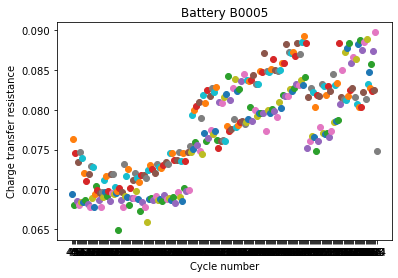

In [5]:
# data visualization of Charge transfer resistance vs cycle number

for cycle in impedance_data.keys():
    plt.plot(cycle, impedance_data[cycle]["rct"], 'o')
    plt.ylabel('Charge transfer resistance')
    plt.xlabel('Cycle number')
    plt.title('Battery B0005')
plt.show()

### discharge data charecteristics

#### voltage vs. time

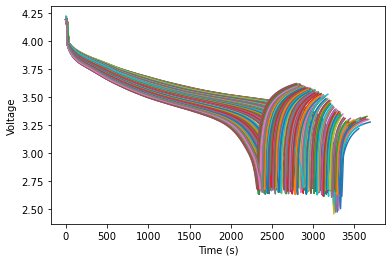

In [6]:
# voltage vs. time graph

for cycle in discharge_data.keys():
    plt.plot(discharge_data[cycle]["time"], discharge_data[cycle]["voltage_battery"], '-')
    plt.ylabel('Voltage')
    plt.xlabel('Time (s)')
plt.show()

#### voltage load vs. time

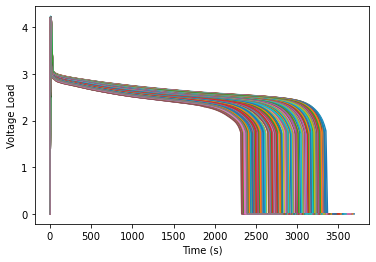

In [7]:
# voltage load vs. time graph

for cycle in discharge_data.keys():
    plt.plot(discharge_data[cycle]["time"], discharge_data[cycle]["voltage_load"], '-')
    plt.ylabel('Voltage Load')
    plt.xlabel('Time (s)')
plt.show()

#### current load vs. time

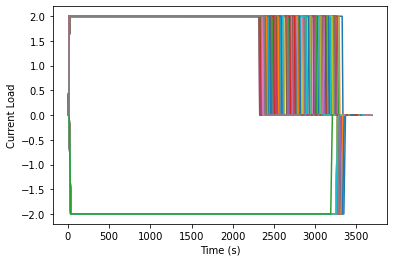

In [8]:
# current load vs. time graph

for cycle in discharge_data.keys():
    plt.plot(discharge_data[cycle]["time"], discharge_data[cycle]["current_load"], '-')
    plt.ylabel('Current Load')
    plt.xlabel('Time (s)')
plt.show()

#### current vs. time

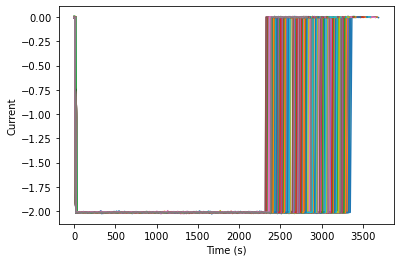

In [9]:
# current vs. time graph

for cycle in discharge_data.keys():
    plt.plot(discharge_data[cycle]["time"], discharge_data[cycle]["current_battery"], '-')
    plt.ylabel('Current')
    plt.xlabel('Time (s)')
plt.show()

#### temperature vs. time

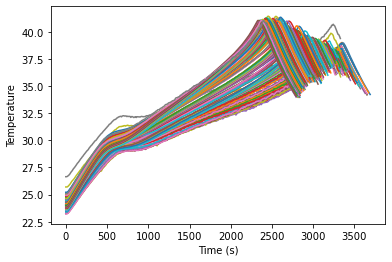

In [10]:
# temperatute vs. time graph

for cycle in discharge_data.keys():
    plt.plot(discharge_data[cycle]["time"], discharge_data[cycle]["temp_battery"], '-')
    plt.ylabel('Temperature')
    plt.xlabel('Time (s)')
plt.show()

### charging cycle charecteristics

#### voltage vs. time

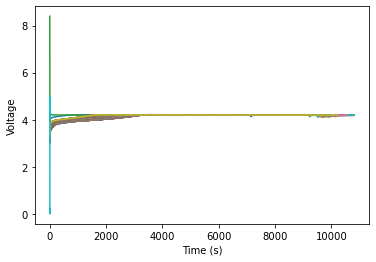

In [11]:
# voltage vs. time graph

for cycle in charge_data.keys():
    plt.plot(charge_data[cycle]["time"], charge_data[cycle]["voltage_battery"], '-')
    plt.ylabel('Voltage')
    plt.xlabel('Time (s)')
plt.show()

### current vs. time

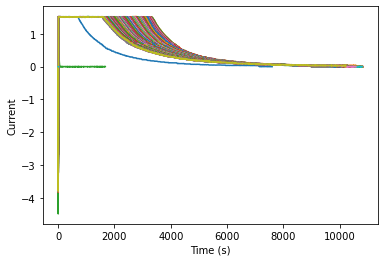

In [12]:
# current vs. time graph

for cycle in charge_data.keys():
    plt.plot(charge_data[cycle]["time"], charge_data[cycle]["current_battery"], '-')
    plt.ylabel('Current')
    plt.xlabel('Time (s)')
plt.show()

### current load vs. time

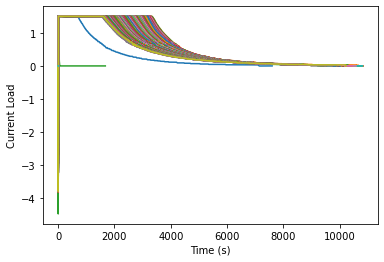

In [13]:
# current load vs. time graph

for cycle in charge_data.keys():
    plt.plot(charge_data[cycle]["time"], charge_data[cycle]["current_load"], '-')
    plt.ylabel('Current Load')
    plt.xlabel('Time (s)')
plt.show()

#### temperature vs. time

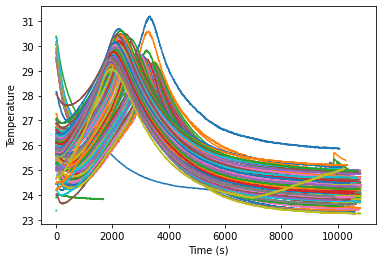

In [14]:
# temperature vs. time graph

for cycle in charge_data.keys():
    plt.plot(charge_data[cycle]["time"], charge_data[cycle]["temp_battery"], '-')
    plt.ylabel('Temperature')
    plt.xlabel('Time (s)')
plt.show()

#### voltage load vs. time

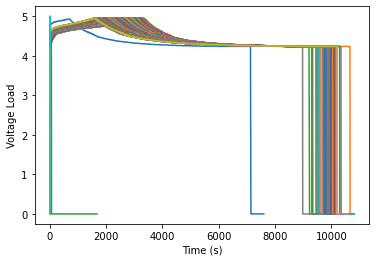

In [15]:
# voltage load vs. time graph

for cycle in charge_data.keys():
    plt.plot(charge_data[cycle]["time"], charge_data[cycle]["voltage_load"], '-')
    plt.ylabel('Voltage Load')
    plt.xlabel('Time (s)')
plt.show()

#### voltage load vs. time

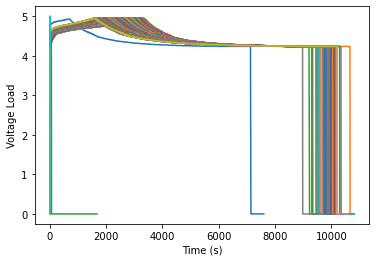

In [16]:
# voltage load vs. time graph

for cycle in charge_data.keys():
    plt.plot(charge_data[cycle]["time"], charge_data[cycle]["voltage_load"], '-')
    plt.ylabel('Voltage Load')
    plt.xlabel('Time (s)')
plt.show()

### Impedance cycle charecteristics

#### sense current vs. battery impedance

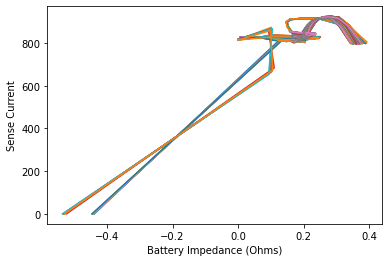

In [17]:
# sense current vs. battery impedance graph

for cycle in impedance_data.keys():
    plt.plot(impedance_data[cycle]["battery_impedance"]["real"], impedance_data[cycle]["sense_current"]["real"], '-')
    plt.ylabel('Sense Current')
    plt.xlabel('Battery Impedance (Ohms)')
plt.show()

#### battery current vs. battery impedance

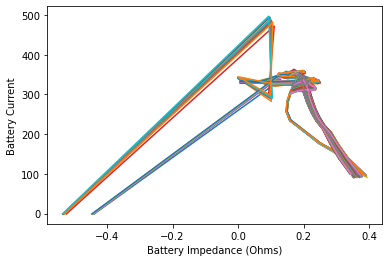

In [18]:
# battery current vs. battery impedance graph

for cycle in impedance_data.keys():
    plt.plot(impedance_data[cycle]["battery_impedance"]["real"], impedance_data[cycle]["battery_current"]["real"], '-')
    plt.ylabel('Battery Current')
    plt.xlabel('Battery Impedance (Ohms)')
plt.show()

In [19]:
# load .mat battery data into dataframe for building model

def load_matdata(battery):
  mat = loadmat('./BatteryAgingARC-FY08Q4/' + battery + '.mat')
  print('Total data in dataset: ', len(mat[battery][0, 0]['cycle'][0]))
  counter = 0
  dataset = []
  capacity_data = []
  
  for i in range(len(mat[battery][0, 0]['cycle'][0])):
    row = mat[battery][0, 0]['cycle'][0, i]
    if row['type'][0] == 'discharge':
      ambient_temperature = row['ambient_temperature'][0][0]
      date_time = datetime.datetime(int(row['time'][0][0]),
                               int(row['time'][0][1]),
                               int(row['time'][0][2]),
                               int(row['time'][0][3]),
                               int(row['time'][0][4])) + datetime.timedelta(seconds=int(row['time'][0][5]))
      data = row['data']
      capacity = data[0][0]['Capacity'][0][0]
      for j in range(len(data[0][0]['Voltage_measured'][0])):
        voltage_measured = data[0][0]['Voltage_measured'][0][j]
        current_measured = data[0][0]['Current_measured'][0][j]
        temperature_measured = data[0][0]['Temperature_measured'][0][j]
        current_load = data[0][0]['Current_load'][0][j]
        voltage_load = data[0][0]['Voltage_load'][0][j]
        time = data[0][0]['Time'][0][j]
        dataset.append([counter + 1, ambient_temperature, date_time, capacity,
                        voltage_measured, current_measured,
                        temperature_measured, current_load,
                        voltage_load, time])
      capacity_data.append([counter + 1, ambient_temperature, date_time, capacity])
      counter = counter + 1
  print(dataset[0])
  return [pd.DataFrame(data=dataset,
                       columns=['cycle', 'ambient_temperature', 'datetime',
                                'capacity', 'voltage_measured',
                                'current_measured', 'temperature_measured',
                                'current_load', 'voltage_load', 'time']),
          pd.DataFrame(data=capacity_data,
                       columns=['cycle', 'ambient_temperature', 'datetime',
                                'capacity'])]
dataset_df, capacity_df = load_matdata('B0005')
pd.set_option('display.max_columns', 20)
print(dataset_df.head())
dataset_df.describe()

Total data in dataset:  616
[1, 24, datetime.datetime(2008, 4, 2, 15, 25, 41), 1.8564874208181574, 4.191491807505295, -0.004901589207462691, 24.330033885570543, -0.0006, 0.0, 0.0]
   cycle  ambient_temperature            datetime  capacity  voltage_measured  \
0      1                   24 2008-04-02 15:25:41  1.856487          4.191492   
1      1                   24 2008-04-02 15:25:41  1.856487          4.190749   
2      1                   24 2008-04-02 15:25:41  1.856487          3.974871   
3      1                   24 2008-04-02 15:25:41  1.856487          3.951717   
4      1                   24 2008-04-02 15:25:41  1.856487          3.934352   

   current_measured  temperature_measured  current_load  voltage_load    time  
0         -0.004902             24.330034       -0.0006         0.000   0.000  
1         -0.001478             24.325993       -0.0006         4.206  16.781  
2         -2.012528             24.389085       -1.9982         3.062  35.703  
3         -2.

,cycle,ambient_temperature,capacity,voltage_measured,current_measured,temperature_measured,current_load,voltage_load,time
count,50285.000000,50285.0,50285.000000,50285.000000,50285.000000,50285.000000,50285.000000,50285.000000,50285.000000
mean,88.125942,24.0,1.560345,3.515268,-1.806032,32.816991,1.362700,2.308406,1546.208924
std,45.699687,0.0,0.182380,0.231778,0.610502,3.987515,1.313698,0.800300,906.640295
min,1.000000,24.0,1.287453,2.455679,-2.029098,23.214802,-1.998400,0.000000,0.000000
25%,50.000000,24.0,1.386229,3.399384,-2.013415,30.019392,1.998000,2.388000,768.563000
50%,88.000000,24.0,1.538237,3.511664,-2.012312,32.828944,1.998200,2.533000,1537.031000
75%,127.000000,24.0,1.746871,3.660903,-2.011052,35.920887,1.998200,2.690000,2305.984000
max,168.000000,24.0,1.856487,4.222920,0.007496,41.450232,1.998400,4.238000,3690.234000


### Aging process graph
The following graph shows the aging process of the battery as the charge cycles progress. The horizontal line represents the threshold related to what can be considered the end of the battery's life cycle.

Text(0.5, 1.0, 'Discharge B0005')

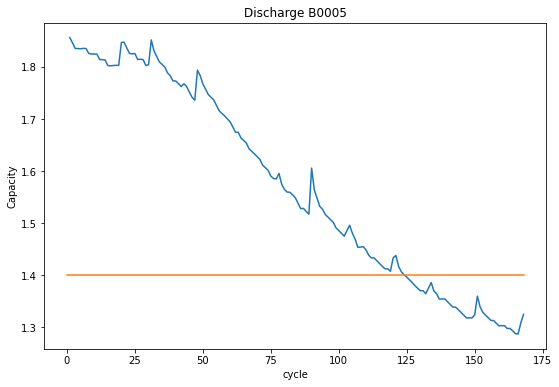

In [20]:
# aging process graph

plot_df = capacity_df.loc[(capacity_df['cycle']>=1),['cycle','capacity']]
#sns.set_style("darkgrid")
plt.figure(figsize=(9, 6))
plt.plot(plot_df['cycle'], plot_df['capacity'])
#Draw threshold
plt.plot([0.,len(capacity_df)], [1.4, 1.4])
plt.ylabel('Capacity')
# make x-axis ticks legible
adf = plt.gca().get_xaxis().get_major_formatter()
plt.xlabel('cycle')
plt.title('Discharge B0005')

#### SoH (State Of Health) Calculation
It is also necessary to calculate the SoH of the battery, since this is the data that will be predicted using the * deep learning * model.

In [21]:
# SoH calculation

attributes=['cycle', 'datetime', 'capacity']
discharge_element = capacity_df[attributes]
C = discharge_element['capacity'][0]
for i in range(len(discharge_element)):
    discharge_element['SoH']=(discharge_element['capacity'])/C
print(discharge_element.head(5))

   cycle            datetime  capacity       SoH
0      1 2008-04-02 15:25:41  1.856487  1.000000
1      2 2008-04-02 19:43:48  1.846327  0.994527
2      3 2008-04-03 00:01:06  1.835349  0.988614
3      4 2008-04-03 04:16:37  1.835263  0.988567
4      5 2008-04-03 08:33:25  1.834646  0.988235


### SoH Graph
Similarly to what has been done previously, a graph of the SoH is made for each cycle, the horizontal line represents the threshold of 70% in which the battery already fulfills its life cycle and it is advisable to make the change.

Text(0.5, 1.0, 'Discharge B0005')

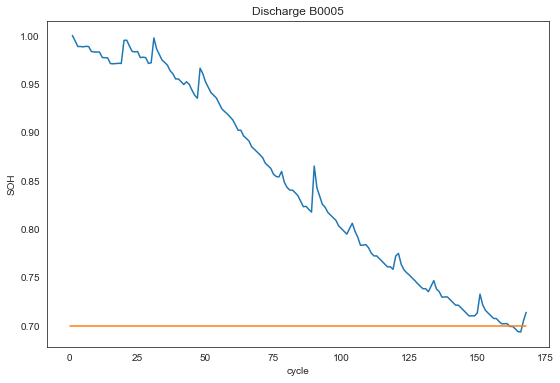

In [22]:
# SoH graph

plot_df = discharge_element.loc[(discharge_element['cycle']>=1),['cycle','SoH']]
sns.set_style("white")
plt.figure(figsize=(9, 6))
plt.plot(plot_df['cycle'], plot_df['SoH'])
#Draw threshold
plt.plot([0.,len(capacity_df)], [0.70, 0.70])
plt.ylabel('SOH')
# make x-axis ticks legible
adf = plt.gca().get_xaxis().get_major_formatter()
plt.xlabel('cycle')
plt.title('Discharge B0005')

### Training phase for calculating SoH
The dataset is prepared in such a way that it can be used by Tensorflow in the training phase, for this, two structures are created corresponding to the input and output expected to be obtained. For the input data, the relevant characteristics of the dataset are filtered, which are:

* Battery capacity
* Voltage
* Current
* Temperature
* Charging voltage
* Charging current
* Instant of time (from the start of the download)

For the output data, the SoH of the battery is calculated and in both input and output cases, the values are normalized to a range of values between [0-1].

In [23]:
# training phase of SoH calculation

C = dataset_df['capacity'][0]
soh = []
for i in range(len(dataset_df)):
  soh.append([dataset_df['capacity'][i] / C])
soh = pd.DataFrame(data=soh, columns=['SoH'])

attributes_ds=['capacity', 'voltage_measured', 'current_measured',
         'temperature_measured', 'current_load', 'voltage_load', 'time']
train_dataset = dataset_df[attributes_ds]
sc = MinMaxScaler(feature_range=(0,1))
train_dataset = sc.fit_transform(train_dataset)
print(train_dataset.shape)
print(soh.shape)

(50285, 7)
(50285, 1)


Preparation of the model, 3 dense layers are used, and the parameters are used as they are in the paper: 3 dense layers and one dropout, and one of the ADAM type is used as optimizer

In [24]:
# model building 

model = Sequential()
model.add(Dense(8, activation='relu', input_dim=train_dataset.shape[1]))
model.add(Dense(8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dropout(rate=0.25))
model.add(Dense(1))
model.summary()
model.compile(optimizer=Adam(beta_1=0.9, beta_2=0.999, epsilon=1e-08), loss='mean_absolute_error')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 64        
                                                                 
 dense_1 (Dense)             (None, 8)                 72        
                                                                 
 dense_2 (Dense)             (None, 8)                 72        
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 217
Trainable params: 217
Non-trainable params: 0
_________________________________________________________________


### The model is trained, 50 epochs are used for training

In [25]:
# model trained

model.fit(x=train_dataset, y=soh.to_numpy(), batch_size=25, epochs=50)

Epoch 1/50
2012/2012 [==============================] - 4s 2ms/step - loss: 0.1035
Epoch 2/50
2012/2012 [==============================] - 3s 1ms/step - loss: 0.0233
Epoch 3/50
2012/2012 [==============================] - 3s 2ms/step - loss: 0.0220
Epoch 4/50
2012/2012 [==============================] - 3s 2ms/step - loss: 0.0213
Epoch 5/50
2012/2012 [==============================] - 3s 2ms/step - loss: 0.0211
Epoch 6/50
2012/2012 [==============================] - 3s 2ms/step - loss: 0.0208
Epoch 7/50
2012/2012 [==============================] - 3s 1ms/step - loss: 0.0208
Epoch 8/50
2012/2012 [==============================] - 3s 1ms/step - loss: 0.0206
Epoch 9/50
2012/2012 [==============================] - 3s 2ms/step - loss: 0.0207
Epoch 10/50
2012/2012 [==============================] - 3s 2ms/step - loss: 0.0206
Epoch 11/50
2012/2012 [==============================] - 3s 2ms/step - loss: 0.0205
Epoch 12/50
2012/2012 [==============================] - 3s 2ms/step - loss: 0.0205
E

### Testing to test the SoH prediction model
To test the correctness of the model, the information of the same battery is loaded (B0006)

In [26]:
# Testing SoH prediction

dataset_val, capacity_val = load_matdata('B0006')
attributes_ms=['cycle', 'datetime', 'capacity']
discharge_element_ms = capacity_val[attributes_ms]
C = discharge_element_ms['capacity'][0]
for i in range(len(discharge_element_ms)):
    discharge_element_ms['SoH']=(discharge_element_ms['capacity']) / C
print(dataset_val.head(5))
print(discharge_element_ms.head(5))

Total data in dataset:  616
[1, 24, datetime.datetime(2008, 4, 2, 15, 25, 41), 2.035337591005598, 4.179799607333447, -0.0023663271409738672, 24.277567510331888, -0.0006, 0.0, 0.0]
   cycle  ambient_temperature            datetime  capacity  voltage_measured  \
0      1                   24 2008-04-02 15:25:41  2.035338          4.179800   
1      1                   24 2008-04-02 15:25:41  2.035338          4.179823   
2      1                   24 2008-04-02 15:25:41  2.035338          3.966528   
3      1                   24 2008-04-02 15:25:41  2.035338          3.945886   
4      1                   24 2008-04-02 15:25:41  2.035338          3.930354   

   current_measured  temperature_measured  current_load  voltage_load    time  
0         -0.002366             24.277568       -0.0006         0.000   0.000  
1          0.000434             24.277073       -0.0006         4.195  16.781  
2         -2.014242             24.366226       -1.9990         3.070  35.703  
3         -2.

A table is created containing the real SoH and the SoH predicted by the network and the root of the mean square error is calculated.

In [27]:
# Table (Actual vs. predicted SoH)

attributes_mp =['capacity', 'voltage_measured', 'current_measured',
        'temperature_measured', 'current_load', 'voltage_load', 'time']
soh_prediction = model.predict(sc.fit_transform(dataset_val[attributes_mp]))
print(soh_prediction.shape)

C = dataset_val['capacity'][0]
soh = []
for i in range(len(dataset_val)):
  soh.append(dataset_val['capacity'][i] / C)
new_soh = dataset_val.loc[(dataset_val['cycle'] >= 1), ['cycle']]
new_soh['Actual SoH'] =  soh
new_soh['Predicted SoH'] = soh_prediction
new_soh = new_soh.groupby(['cycle']).mean().reset_index()
print(new_soh.head(10))
rms = np.sqrt(mean_squared_error(new_soh['Actual SoH'], new_soh['Predicted SoH']))
print('Root Mean Square Error: ', rms)

(50285, 1)
   cycle  Actual SoH  Predicted SoH
0      1    1.000000       0.992797
1      2    0.994990       0.990005
2      3    0.989185       0.986531
3      4    0.989165       0.986513
4      5    0.982898       0.982272
5      6    0.989467       0.986622
6      7    0.989075       0.986401
7      8    0.967304       0.971671
8      9    0.966997       0.971481
9     10    0.961625       0.967688
Root Mean Square Error:  0.08794748913594322


### Actual SoH vs. Predicted SoH
Finally both SoH are plotted to observe their differences

Text(0.5, 1.0, 'Discharge B0006')

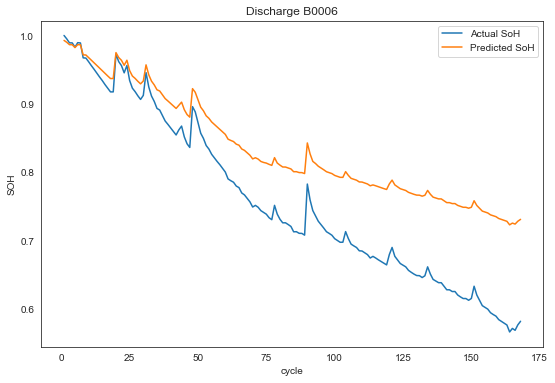

In [28]:
# Actual vs. predicted SoH graph

plot_df = new_soh.loc[(new_soh['cycle']>=1),['cycle','Actual SoH', 'Predicted SoH']]
sns.set_style("white")
plt.figure(figsize=(9, 6))
plt.plot(plot_df['cycle'], plot_df['Actual SoH'], label='Actual SoH')
plt.plot(plot_df['cycle'], plot_df['Predicted SoH'], label='Predicted SoH')
#Draw threshold
#plt.plot([0.,len(capacity)], [0.70, 0.70], label='Threshold')
plt.ylabel('SOH')
# make x-axis ticks legible
adf = plt.gca().get_xaxis().get_major_formatter()
plt.xlabel('cycle')
plt.legend()
plt.title('Discharge B0006')

For the estimation of SoH, it can be seen that the data pattern is learned by the model correctly, as predicted by the theory, since the shape of the curves is almost identical. The SoH shown has the same behavior as expected in theory, which is corroborated with the root mean square error value of the graph in illustration 8, whose value of 9% is very similar to that found previously. This reaffirms the precision when making the prediction.

### RUL estimation
In the same way that was done for the estimation of SoH, the training and testing dataset is prepared, in this particular case the battery capacity data is used using the first data of the first 50 cycles to predict the capacity in the following cycles in such a way as to be able to know when the threshold of the battery is reached and estimate the remaining cycles to reach the End of Life of the battery

In [29]:
# RUL estimation: splitting test and train data set

dataset_val, capacity_val = load_matdata('B0007')
attributes_rul=['cycle', 'datetime', 'capacity']
discharge_element_rul = capacity_val[attributes_rul]
rows=['cycle','capacity']
dataset=discharge_element_rul[rows]
data_train=dataset[(dataset['cycle']<50)]
data_set_train=data_train.iloc[:,1:2].values
data_test=dataset[(dataset['cycle']>=50)]
data_set_test=data_test.iloc[:,1:2].values

sc=MinMaxScaler(feature_range=(0,1))
data_set_train=sc.fit_transform(data_set_train)
data_set_test=sc.transform(data_set_test)

X_train=[]
y_train=[]
#take the last 10t to predict 10t+1
for i in range(10,49):
    X_train.append(data_set_train[i-10:i,0])
    y_train.append(data_set_train[i,0])
X_train,y_train=np.array(X_train),np.array(y_train)
 
X_train=np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))

Total data in dataset:  616
[1, 24, datetime.datetime(2008, 4, 2, 15, 25, 41), 1.89105229539079, 4.199359521791473, -0.0018658918833680202, 23.93704394613529, -0.0004, 0.0, 0.0]


### Model training using LSTM
In this section the model is trained, based on the proposal of [2] and making use of LSTM-type networks instead of standard neural networks.

In [30]:
# model building using LSTM

model_lstm = Sequential()
model_lstm.add(LSTM(units=200, return_sequences=True, input_shape=(X_train.shape[1],1)))
model_lstm.add(Dropout(0.3))
model_lstm.add(LSTM(units=200, return_sequences=True))
model_lstm.add(Dropout(0.3))
model_lstm.add(LSTM(units=200, return_sequences=True))
model_lstm.add(Dropout(0.3))
model_lstm.add(LSTM(units=200))
model_lstm.add(Dropout(0.3))
model_lstm.add(Dense(units=1))
model_lstm.compile(optimizer='adam',loss='mean_squared_error')
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 200)           161600    
                                                                 
 dropout_1 (Dropout)         (None, 10, 200)           0         
                                                                 
 lstm_1 (LSTM)               (None, 10, 200)           320800    
                                                                 
 dropout_2 (Dropout)         (None, 10, 200)           0         
                                                                 
 lstm_2 (LSTM)               (None, 10, 200)           320800    
                                                                 
 dropout_3 (Dropout)         (None, 10, 200)           0         
                                                                 
 lstm_3 (LSTM)               (None, 200)              

In [31]:
# Model trained

model_lstm.fit(X_train,y_train,epochs=200,batch_size=25)

Epoch 1/200
2/2 [==============================] - 5s 32ms/step - loss: 0.3541
Epoch 2/200
2/2 [==============================] - 0s 25ms/step - loss: 0.1168
Epoch 3/200
2/2 [==============================] - 0s 28ms/step - loss: 0.1519
Epoch 4/200
2/2 [==============================] - 0s 36ms/step - loss: 0.0423
Epoch 5/200
2/2 [==============================] - 0s 31ms/step - loss: 0.0910
Epoch 6/200
2/2 [==============================] - 0s 29ms/step - loss: 0.0837
Epoch 7/200
2/2 [==============================] - 0s 42ms/step - loss: 0.0481
Epoch 8/200
2/2 [==============================] - 0s 49ms/step - loss: 0.0465
Epoch 9/200
2/2 [==============================] - 0s 52ms/step - loss: 0.0562
Epoch 10/200
2/2 [==============================] - 0s 53ms/step - loss: 0.0414
Epoch 11/200
2/2 [==============================] - 0s 53ms/step - loss: 0.0472
Epoch 12/200
2/2 [==============================] - 0s 40ms/step - loss: 0.0548
Epoch 13/200
2/2 [==============================]

### Model Testing

In [32]:
# model testing

print(len(data_test))
data_total = pd.concat((data_train['capacity'], data_test['capacity']),axis=0)
inputs = data_total[len(data_total)-len(data_test)-10:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

119


In [33]:
# RMSE (Root Mean Square Error) calculation

X_test = []
for i in range(10,129):
    X_test.append(inputs[i-10:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
prediction = model_lstm.predict(X_test)
print(prediction.shape)
prediction = sc.inverse_transform(prediction)
prediction = prediction[:,0]
tests = data_test.iloc[:,1:2]
rmse = np.sqrt(mean_squared_error(tests, prediction))
print('Test RMSE: %.3f' % rmse)
metrics.r2_score(tests,prediction)

(119, 1)
Test RMSE: 0.069


0.5780001984791312

As can be seen, the mean RMSE is 0.05 (5%), which is very close to the values observed in the literature using this type of network.

C:\Users\AMBUJK~1\AppData\Local\Temp/ipykernel_1624/3020060402.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['pre'] = prediction


Text(0.5, 1.0, 'Discharge B0005 (prediction) start in cycle 50 -RULe=-8, window-size=10')

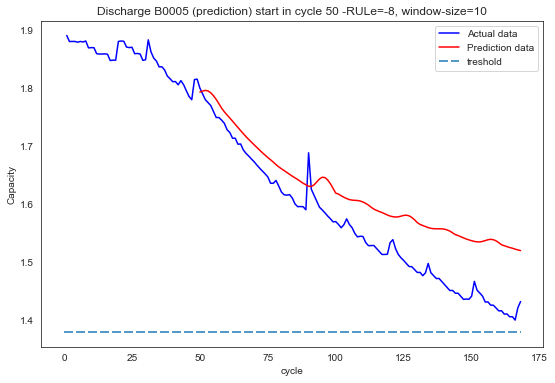

In [34]:
# RUL: Actual failure vs. predicted failure vs. thresold

ln = len(data_train)
data_test['pre'] = prediction
plot_df = dataset.loc[(dataset['cycle']>=1),['cycle','capacity']]
plot_per = data_test.loc[(data_test['cycle']>=ln),['cycle','pre']]
plt.figure(figsize=(9, 6))
plt.plot(plot_df['cycle'], plot_df['capacity'], label="Actual data", color='blue')
plt.plot(plot_per['cycle'],plot_per['pre'],label="Prediction data", color='red')
#Draw threshold
plt.plot([0.,168], [1.38, 1.38],dashes=[6, 2], label="treshold")
plt.ylabel('Capacity')
# make x-axis ticks legible
adf = plt.gca().get_xaxis().get_major_formatter()
plt.xlabel('cycle')
plt.legend()
plt.title('Discharge B0005 (prediction) start in cycle 50 -RULe=-8, window-size=10')

Finally, it can be seen in the graph that the capacity value and how it behaves over time is very close to the real value and supporting these data, the error in the estimation of the RUL was -8 which makes us understand that The model went ahead by 8 cycles to estimate that the battery reached its end of life.

In [35]:
# Actual, predicted and error RUL calculation

pred=0
Afil=0
Pfil=0
a=data_test['capacity'].values
b=data_test['pre'].values
j=0
k=0
for i in range(len(a)):
    actual=a[i]
    
    if actual<=1.38:
        j=i
        Afil=j
        break
for i in range(len(a)):
    pred=b[i]
    if pred< 1.38:
        k=i
        Pfil=k
        break
print("The Actual fail at cycle number: "+ str(Afil+ln))
print("The prediction fail at cycle number: "+ str(Pfil+ln))
RULerror=Pfil-Afil
print("The error of RUL= "+ str(RULerror)+ " Cycle(s)")

The Actual fail at cycle number: 49
The prediction fail at cycle number: 49
The error of RUL= 0 Cycle(s)
